# Project ML in Finance Group 5
### April 2023


#### Cyrill Stoll, Arthur Schlegel, Aleksandar Kuljanin and Selina Waber


## Introduction

Dean De Cock created the Ames Housing dataset here the link to the [Dataset](https://www.openml.org/search?type=data&sort=runs&id=42165&status=active). This dataset provides information about the sales of residential properties in Ames, Iowa between 2006 and 2010. It consists of 2930 observations and includes a significant amount of explanatory variables, such as 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables, that are used to evaluate the values of homes. 



## Importing Librarys

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 10

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# packages for decision tree / Random forest
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler

# additional packages used for logreg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Function for Printing and Showing Confusion Matrix

In [ ]:
def print_results_crossvalidation(func, X_test, y_test):
  
  std_best_score = func.cv_results_["std_test_score"][func.best_index_]
  print(f"Best parameters: {func.best_params_}")
  print(f"Mean CV score: {func.best_score_:}")
  print(f"Standard deviation of CV score: {std_best_score:}")
  print("Test Score:".format(func.score(X_test, y_test)))

def report(y_true, y_pred):
    
  class_report = metrics.classification_report(y_true, y_pred)
  print(class_report)
  conf_matrix = confusion_matrix(y_true, y_pred, normalize = "all")
  conf_matrix = pd.DataFrame(conf_matrix, ["Class 0", "Class 1", " Class 2", "Class 3", " Class 4"],  ["Class 0", "Class 1", " Class 2", "Class 3", " Class 4"])
  sns.heatmap(conf_matrix, annot = True).set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")
     


## Load Data

In [ ]:
# Load data
df = pd.read_csv("GroupProjectDataSet.csv", sep=',', index_col='Id')
print('Shape of data frame:', df.shape)
df.head()


In [ ]:
df.describe()

### Overview

The data set consists of 1460 observations with 81 variables (including the target variable "(prize) class" and the id variable). 79 variables are descriptive variables that should explain Class.

Quantitative: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

Qualitative: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities

In [ ]:
numCols = list(df.select_dtypes(exclude='object').columns)
print(f"There are {len(numCols)} numerical features:\n", numCols)

In [ ]:
catCols = list(df.select_dtypes(include='object').columns)
print(f"There are {len(catCols)} categorical features:\n", catCols)

## Handling Missing Values

Identifying missing values in data is crucial before determining the appropriate course of action, such as dropping features or imputing missing values, as many machine learning algorithms generate errors when trained on incomplete data.

In [ ]:
# Plot missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing.plot.bar()

In [ ]:
# Assess missing values
cols = df.columns[df.isna().any()]
df_nan = df[cols].copy()
df_nan['Class'] = df['Class']


# Plot missing values 2.0
plt.figure(figsize=(10, 6))
sns.heatmap(df_nan.isna().transpose(),
            cmap="Blues",
            cbar_kws={'label': 'Missing Values'});

In [ ]:
# Percentage of missing values for the variables
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percent], axis=1, keys=['Nr. of missing values', 'Share'])
missing_data.head(22)

### Filling missing values for variables where appropriate

19 variables have missing values. Of the 19 variables four (PoolQC, MiscFeature, Alley, Fence) have more than 50% missing data and one (FireplaceQu) with nearly 50% missing data. But often NA does not mean that there is no data available. Instead (especially for thecategorical variables) it means that the house is lacking this specific object. NA in the PoolQC variable means that there is no pool; NA in the Alley variable means that there is "no alley access". All the descriptions of which NA stand for non-available data and which stand for a missing trait can be found in the data description.





#### Filling Categorical Variables

The following variables have NAs that can be filled:

- PoolQC: Na = No Pool
- MiscFeature: Na = None
- Alley: NA = No alley access
- Fence: NA = No Fence
- FireplaceQu: NA = No Fireplace
- GarageCond: NA = No Garage
- GarageType: NA = No Garage
- GarageFinish: NA = No Garage
- GarageQual: NA = No Garage
- BsmtFinType2: NA = No Basement
- BsmtExposure: NA = No Basement
- BsmtQual: NA = No Basement
- BsmtCond: NA = No Basement
- BsmtFinType1: NA = No Basement
- MasVnrType: NA = None

In [ ]:
## Filling Categorical Variables 

df["PoolQC"] = df["PoolQC"].fillna(value = "No")
df["MiscFeature"] = df["MiscFeature"].fillna(value = "No")
df["Alley"] = df["Alley"].fillna(value = "No")
df["Fence"] = df["Fence"].fillna(value = "No")
df["FireplaceQu"] = df["FireplaceQu"].fillna(value = "No")
df["GarageCond"] = df["GarageCond"].fillna(value = "No")
df["GarageType"] = df["GarageType"].fillna(value = "No")
df["GarageFinish"] = df["GarageFinish"].fillna(value = "No")
df["GarageQual"] = df["GarageQual"].fillna(value = "No")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna(value = "No")
df["BsmtExposure"] = df["BsmtExposure"].fillna(value = "No")
df["BsmtQual"] = df["BsmtQual"].fillna(value = "No")
df["BsmtCond"] = df["BsmtCond"].fillna(value = "No")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna(value = "No")
df["MasVnrType"] = df["MasVnrType"].fillna(value= "No") #newly added

For all but five variables we coud fill the missing data because with them NA indicates the lack of the corresponding trait. For LotFrontage we miss 17% of the values and 5.5% for GarageYrBlt.

#### Filling missing values for numerical data

In [ ]:
## Numerical Variables
missing_numerical = ['GarageArea', 'GarageCars', 'BsmtFinSF1',
                     'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
                     'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

df[missing_numerical] = df[missing_numerical].fillna(0)

#### Filling special variables
 

In [ ]:
# Filling special variables

df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["YearBuilt"]) 
# assuming that the garge was bulit with the house 


df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())



most_frequent= df['Electrical'].value_counts().idxmax()
df["Electrical"] = df["Electrical"].fillna(most_frequent)


## Outliers - To DO -

Because regression models are very sensitive to outlier, we need to be aware of them. In the case of categorical data one can use sklearn's `OneHotEncoder` and specify the `min_frequency` parameter. If you specified the min_frequency parameter, rare categorical values will be assigned `infrequend_sklearn`.

https://medium.com/owl-analytics/categorical-outliers-dont-exist-8f4e82070cb2

## Create New Variables

<mark> Copy pastet from here https://chriskhanhtran.github.io/minimal-portfolio/projects/ames-house-price.html <mark> 
    
Should maybe change that and not copy paste it ???
    
    

In [ ]:
df['totalSqFeet'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['totalBathroom'] = df["FullBath"] + df["BsmtFullBath"] + 0.5 * (df["HalfBath"] + df["BsmtHalfBath"])
df['houseAge'] = df["YrSold"] - df["YearBuilt"]
df['reModeled'] = np.where(df["YearRemodAdd"] == df["YearBuilt"], 0, 1)
df['isNew'] = np.where(df["YrSold"] == df["YearBuilt"], 1, 0)



Dropping columns

In [ ]:
not_used_anymore = ['TotalBsmtSF','1stFlrSF', '2ndFlrSF',
                    "FullBath", "BsmtFullBath", "HalfBath",
                    "BsmtHalfBath", "YearBuilt", "YearRemodAdd"  ]

df= df.drop(not_used_anymore, axis=1)

In [ ]:
df.columns.values

## Feature Engineering


### Dealing with Categorical Features (Encoding Categorical Variables) 

In [ ]:
# Numerical variables that should be handled as categorical variables
df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})

df = df.replace({"MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}})


In [ ]:
# other approach:
#to_factor_cols = ['YrSold', 'MoSold', 'MSSubClass']
#for col in to_factor_cols:
#    X[col] = X[col].apply(str)

## Numerical Features





#### Histograms

In [ ]:
#  Visualize data to gain insights (Histograms)
df.hist(figsize=(30, 20), bins = 15, edgecolor = 'black', grid = False, color = 'royalblue')
plt.suptitle('Histograms of numerical features', x = 0.5, y = 1.02, size = 35)


#### Top 10 numerical variables highly correlated with `Class`:

In [ ]:
#corr_mat = df.corr(numeric_only=False).Class.sort_values(ascending=False)
#corr_mat.head(11)

#### Recursive Feature Elimination

What are the top 10 features selected by Recursive Feature Elimination?


In [ ]:
# Asign columns to feature matrix X interim and response vector y interim
X_interim = df.loc[:, df.columns != "Class"]
y = df["Class"]

from sklearn.model_selection import train_test_split
X_train_interim , X_test_interim, y_train_interim, y_test_interim = train_test_split(X_interim, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    stratify=y)

frames = [X_train_interim, y_train_interim]
df_train_interim = pd.concat(frames, axis=1)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=10, step=1)
selector = rfe.fit(X_train_interim.fillna(0).select_dtypes(exclude='object'), y_train_interim)
selectedFeatures = list(
    X_interim.select_dtypes(exclude='object').columns[selector.support_])
selectedFeatures



 ??????? Can't be !!!!
 
 
 <mark>Can that be?<mark> 



### Overall Quality

Overall quality is a very important feature e.g. higher quality houses are more expensive.

In [ ]:
sns.boxplot(x='OverallQual', y='Class', data=df)
title = plt.title('House Price/Class by Overall Quality')

### Living Area

The price of a house is linearly correlated with its living area. By examining the scatter plot depicted below, it is evident that there exist some outliers in the data, particularly the two houses positioned in the bottom-right corner. These houses have a living area of more than 4000 square feet but are priced lower than Class 2.



In [ ]:
print("Correlation: ", df[['GrLivArea','Class']].corr().iloc[1, 0])
sns.jointplot(x=df['GrLivArea'],y= df['Class'], kind='reg', marginal_kws={'kde': True})


### GarageCars

houses with garage that can hold 4 cars are cheaper than houses with 3 garages.


In [ ]:
sns.boxplot(x='GarageCars', y='Class', data=df)
title = plt.title('House Price/Class by Garage Size')

### House Age

In addition to living area, the age of a house also influences its price significantly. Typically, newer houses command higher prices on average. However, it is worth noting that there are some houses constructed before 1900 that have a relatively high price despite their age.

In [ ]:
sns.scatterplot(x='houseAge', y='Class', data=df)
title = plt.title('House Price/Class by Year Built')


## Lable Encoding ??? 

Ordinal categorical features are label encoded. ??? <mark> copy pastet from https://chriskhanhtran.github.io/minimal-portfolio/projects/ames-house-price.html <mark> does it even make sense??
    

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Ordinal categorical columns
label_encoding_cols = [
    "Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "BsmtQual", "ExterCond", "ExterQual", "FireplaceQu", "Functional",
    "GarageCond", "GarageQual", "HeatingQC", "KitchenQual", "LandSlope",
    "LotShape", "PavedDrive", "PoolQC", "Street", "Utilities"
]

# Apply Label Encoder
label_encoder = LabelEncoder()

for col in label_encoding_cols:
    df[col] = label_encoder.fit_transform(df[col])

## Asign columns to feature matrix X and response vector y


In [ ]:
# Asign columns to feature matrix X and response vector y

X = df.loc[:, df.columns != "Class"]
y = df["Class"] 

print(X.shape)
print(y.shape)

## Adding Dummies

In [ ]:
# factorise the binary variables (no need to create two dummy variables)
# ---> Problem of Multicollinearity 
#Without this the get_dummies would create two variables CentralAir_y and CentralAir_n
X["StreetFac"] = X.Street.factorize()[0]
X["CentralAirFac"] = X.CentralAir.factorize()[0]

In [ ]:
# Factorize categorical values, assign output to X
# create (multiple) dummy variables for a categorical variable
X = pd.get_dummies(X.iloc[:,:]) 

print(X.shape)
X.head()

In [ ]:
X.columns.values

## Partitioning of the Data Set Into Train and Test Set

We are using a 70/30 (training/testing) splitting. (The parameter `random_state=0` fixes the random split in a way such that results are reproducible.)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

A stratified sample is one that maintains the proportion of values as in the original data set. If, for example, the response vector  𝑦 is a binary categorical variable with 25% zeros and 75% ones, `stratify=y` ensures that the random splits have 25% zeros and 75% ones too. Note that `stratify=y` does not mean `stratify=yes` but rather tells the function to take the categorical proportions from response vector `y`.

## Handling Outliers

In [ ]:
out = IsolationForest(random_state = 42).fit(X_train)
out_train = out.predict(X_train)
out_test = out.predict(X_test)


X_train_wout_out = X_train[np.where(out_train == 1, True, False)]
y_train_wout_out = y_train[np.where(out_train == 1, True, False)]
X_test_wout_out = X_test[np.where(out_test == 1, True, False)]
y_test_wout_out = y_test[np.where(out_test == 1, True, False)]

print("Training Set")
print("Shape including outliers: ", X_train.shape)
print("Shape excluding outliers: ", X_train_wout_out.shape)
print("Nr. of outliers removed: ", X_train.shape[0]-X_train_wout_out.shape[0])

print(50*"-")

print("Test Set")
print("Shape including outliers: ", X_test.shape)
print("Shape excluding outliers: ", X_test_wout_out.shape)
print("Nr. of outliers removed: ", X_test.shape[0]-X_test_wout_out.shape[0]) 

In [ ]:
# Using the data without the outliers for the models

# Traning Set
X_train = X_train_wout_out
y_train = y_train_wout_out

# Test Set
X_test = X_test_wout_out
y_test = y_test_wout_out

## Multicollinearity

In [ ]:
## Feature Selection##
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Compute the correlation matrix
corr = df.corr()

# Plotting Heatmap
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot = True)

In [ ]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Sort the correlations with respect to 'Class'
corr_with_class = corr_matrix['Class'].sort_values(ascending=False)

# Print the correlations
print(corr_with_class)

# Select the top 10 features with the highest correlation
top_features = corr_with_class.nlargest(10).index

# Print the top features
print(top_features)

In [ ]:
##VIF## 

# load the data and select features
X = df[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
        'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]

# add a constant to X for the intercept
X = sm.add_constant(X)

# calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# print the VIF table
print(vif)

## Skewness and Normalizing Variables

Linear regression assumes that the data follows a normal distribution, and therefore, transforming skewed data can improve the performance of the models.

In [ ]:
plt.figure(1); plt.title('Distribution of Class')
sns.histplot(data=y, discrete = True)

We see that our "Class" deviates from the normal distribution, is positively/right-skewed skewed and shows peakedness (cortosis).

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df['Class'].skew())
print("Kurtosis: %f" % df['Class'].kurt())

To normalize right-skewed data, log transformation can be used as a method since it pulls the larger values towards the center. However, because log(0) results in NaN, log(1+X) is preferred as a fix for the skewness instead.

In [ ]:
sns.displot(data=y, kind='hist', kde=True)
title = plt.title("House Price Distribution")

In [ ]:
y_trafo = np.log(1 + y)
sns.displot(data=y_trafo, kind='hist', kde=True)
title = plt.title("House Price Distribution Transformation")

## Feature Scaling

Standardizing the dataset before running machine learning algorithms is generally recommended, except for Decision Tree and Random Forest models. This is because optimization methods and gradient descent algorithms tend to perform and converge faster on features that are similarly scaled.

However, outliers can have a negative impact on the sample mean and standard deviation, and models like Lasso and others are highly sensitive to outliers. In such cases, using the median and interquartile range is a better alternative. For this reason, the <mark> RobustScaler?? or StandardScaler? <mark> method is used to transform the training data.
    

In [ ]:
from sklearn.preprocessing import MinMaxScaler 

# Get cols to scale
cols_scl = X.columns.values[:]

# Apply MinMaxScaler on continuous columns only (check dummies!!!)
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[cols_scl])  # fit & transform
X_test_norm  = mms.transform(X_test[cols_scl])  # ONLY transform

In [ ]:
from sklearn.preprocessing import StandardScaler 

# Apply StandardScaler on continuous columns only
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train[cols_scl])  # fit & transform
X_test_std  = stdsc.transform(X_test[cols_scl])  # ONLY transform

# Logistic Regression

In [ ]:
################### Feature Scaling with MinMaxScalar #################

# Get cols to scale
cols_scl = X.columns.values[:]

# Apply MinMaxScaler on continuous columns only
mms = MinMaxScaler()
X_train_norm_MMS = mms.fit_transform(X_train)  # fit & transform
X_test_norm_MMS  = mms.transform(X_test)  # ONLY transform

In [ ]:
#################### Feature Scaling with StandartScalar ##################
from sklearn.preprocessing import StandardScaler

#scaling
scaler = StandardScaler()
scaler.fit(X_train)

#transforming 
X_train_norm_STD = scaler.transform(X_train)
X_test_norm_STD = scaler.transform(X_test)

In [ ]:
# Train logistic regression model (using MinMaxStandardization)
lr = LogisticRegression().fit(X_train_norm_MMS,y_train)
y_pred = lr.predict(X_test_norm_MMS)

In [ ]:
report(y_test,y_pred) #Report of LogReg using all features and MinMaxStandardization

In [ ]:
##### Hyperparametrization of Logistic Regression (using MinMaxStandardization)

#hyperparameters
param_grid_lr_MMS = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # Algorithm to use in the optimization problem.
    "penalty": ["l1","l2"], #specify norm of penalty
    "C": np.logspace(-3,3,15), #smaller values specify stronger regularization    
}

# Run brute-force grid search
lr_grid = GridSearchCV(estimator=LogisticRegression(), #model
                             param_grid=param_grid_lr_MMS, #hyperparameters
                             verbose=1, 
                             cv=10, #number of folds
                             n_jobs=-1) #using all cores of computer

# fitting the model
lr_grid.fit(X_train_norm_MMS, y_train)
y_pred = lr_grid.predict(X_test_norm_MMS)

In [ ]:
report(y_test,y_pred) #Report of LogReg using all features, MinMaxStandardization and Hyperparametrization of usual LogReg-Parameters

In [ ]:
# Train logistic regression model (using StandardScalar)
lr = LogisticRegression().fit(X_train_norm_STD,y_train)
y_pred = lr.predict(X_test_norm_STD)

In [ ]:
report(y_test,y_pred) #Report of LogReg using StandartScalar Standardization

In [ ]:
##### Hyperparametrization of Logistic Regression (using StandardScalar)

#hyperparameters
param_grid_lr_STD = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # Algorithm to use in the optimization problem.
    "penalty": ["l1","l2"], #specify norm of penalty
    "C": np.logspace(-3,3,15), #smaller values specify stronger regularization    
}
# Run brute-force grid search
lr_grid = GridSearchCV(estimator=LogisticRegression(), #model
                             param_grid=param_grid_lr_STD, #hyperparameters
                             verbose=1, 
                             cv=10, #number of folds
                             n_jobs=-1) #using all cores of computer
# fitting the model
lr_grid.fit(X_train_norm_STD, y_train)

y_pred = lr_grid.predict(X_test_norm_STD)

In [ ]:
report(y_test,y_pred) #Report of LogReg usuing StandartScalar Standardization and Hyperparametrization

In [2]:
################################## Random Forest Feature Selection for Logistic Regression##########################################

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train_norm_STD,y_train)
sel.get_support
selected_feat= X_train.columns[(sel.get_support())]

NameError: name 'SelectFromModel' is not defined

In [ ]:
# Data set with just Random Forest Features
X_train_rf = X_train[selected_feat]
X_test_rf = X_test[selected_feat]

#Feature Scaling using StandardScalar
scaler = StandardScaler()
scaler.fit(X_train_rf)
X_train_rf_STD = scaler.transform(X_train_rf)
X_test_rf_STD= scaler.transform(X_test_rf)

In [ ]:
#Logistic Regression
logModel_rf = LogisticRegression().fit(X_train_rf_STD,y_train)
y_pred_rf = logModel_rf.predict(X_test_rf_STD)

In [1]:
report(y_test,y_pred_rf) #Report of LogReg usuing StandartScalar Standardization and Random Forest Feature Selection

NameError: name 'report' is not defined

In [ ]:
# Hyperparametrization on Model using Random Forest Feature Selection

#hyperparameters
param_grid_lr_rf = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # Algorithm to use in the optimization problem.
    "penalty": ["l1","l2"], #specify norm of penalty
    "C": np.logspace(-3,3,15), #smaller values specify stronger regularization    
}

lr_rf_grid = GridSearchCV(estimator=LogisticRegression(),
                          param_grid=param_grid_lr_rf,
                          cv = 10,
                          n_jobs=-1
                          )
lr_rf_grid.fit(X_train_rf_STD,y_train)
y_pred_rf = logModel_rf.predict(X_test_rf_STD)

In [ ]:
report(y_test,y_pred) #Report of LogReg using StandartScalar Standardization, Random Forest Feature Selection and Hyperparam

In [98]:
############### XGBoost Feature Selection for Logistic Regression ########################
# Notice that the coding process is analogous to Random Forest Feature Selection
xgbc= xgb.XGBClassifier( objective = "multi:softmax", random_state = 42)
select_xgbc = SelectFromModel(estimator = xgbc, threshold = "median")
select_xgbc.fit(X_train, y_train)

list_train_xgbc= X_train.columns[(select_xgbc.get_support())]
list_test_xgbc= X_test.columns[(select_xgbc.get_support())]

X_train_xgbc = X_train[list_train_xgbc]
X_test_xgbc = X_test[list_test_xgbc]

In [99]:
scaler = StandardScaler()
scaler.fit(X_train_xgbc)

X_train_xgbc_STD = scaler.transform(X_train_xgbc)
X_test_xgbc_STD= scaler.transform(X_test_xgbc)

In [105]:
logModel_xgbc = LogisticRegression().fit(X_train_xgbc_STD,y_train)
y_pred_xgbc = logModel_xgbc.predict(X_test_xgbc_STD)

              precision    recall  f1-score   support

         0.0       0.71      0.68      0.69        37
         1.0       0.90      0.88      0.89       273
         2.0       0.66      0.76      0.70        94
         3.0       0.52      0.42      0.47        26
         4.0       0.57      0.50      0.53         8

    accuracy                           0.80       438
   macro avg       0.67      0.65      0.66       438
weighted avg       0.80      0.80      0.80       438



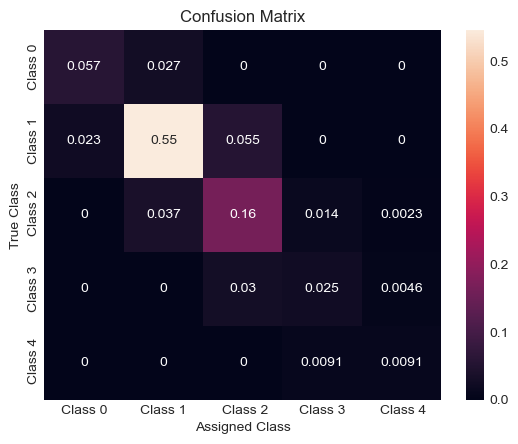

In [106]:
report(y_test,y_pred_xgbc)

In [110]:
################# PCA Dimension Reduction on LogReg #########################

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a PCA object and fit it to the scaled data
pca = PCA(n_components=3) # Select the number of components you want to keep
pca.fit(X_train_scaled)

# Transform the data to the selected number of components
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train the logistic regression model on the transformed data
logModel_pca = LogisticRegression().fit(X_train_pca, y_train)
y_pred_pca = logModel_pca.predict(X_test_pca)

              precision    recall  f1-score   support

         0.0       0.76      0.59      0.67        37
         1.0       0.82      0.88      0.85       273
         2.0       0.57      0.59      0.58        94
         3.0       0.60      0.35      0.44        26
         4.0       1.00      0.25      0.40         8

    accuracy                           0.75       438
   macro avg       0.75      0.53      0.59       438
weighted avg       0.75      0.75      0.74       438



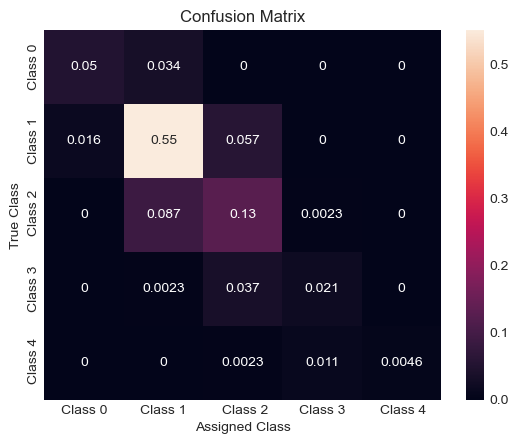

In [111]:
report(y_test,y_pred_pca) #Results on PCA for LogReg

#### Summary on Logistic Regression

#### Using MinMaxScalar 
We find the following Scores:
f1 Score:         0.78

#### Using MinMaxScalar and hyperparametrization
We find the following Scores:
f1 Score:         0.81

#### Using StandardScalar
We find the following Scores:
f1 Score:         0.76

#### Using StandardScalar and hyperparametrization 
We find the following Scores:
f1 Score:         0.82

#### Using StandardScaler and  RandomForest Feature Selection 
We find the following Scores:
f1 Score:         0.83

#### Using StandardScaler, RandomForest Feature Selection and Hyperparametrization 
We find the following Scores:
f1 Score:         0.82

#### Using StandardScaler and XBoost:
We find the following Scores:
f1 Score:         0.80

#### Using StandardScaler and PCA
We find the following Scores:
f1 Score:         0.75

# KNN

In [ ]:
#KNN-Model##
train_df = pd.DataFrame(data=X_train, columns=X.columns)
train_df['Class'] = y_train

test_df = pd.DataFrame(data=X_test, columns=X.columns)
test_df['Class'] = y_test

X_train = train_df[['Class', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
y_train = train_df['Class']

# Initialize the KNN classifier with k=20
knn = KNeighborsClassifier(n_neighbors=20)

# Fit the KNN model on the training data
knn.fit(X_train, y_train)

# Use the trained KNN model to make predictions on the test data
X_test = test_df[['Class', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
y_test = test_df['Class']
y_pred = knn.predict(X_test)

# Compute the accuracy of the KNN model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute the classification report for the KNN model on the test data
report = classification_report(y_test, y_pred)
print(report)
print(metrics.confusion_matrix(y_test, y_pred))

The model correctly classified 75% of the instances in the test set.
The report indicates that the model performs well in predicting class 1, with a precision of 0.82 and a recall of 0.90, indicating that it correctly predicted a high proportion of the instances belonging to this class. However, the model performed less well in predicting classes 0 and 3, with a precision and recall of around 0.5. The model had moderate performance for class 2, with a precision and recall of around 0.6, and poor performance for class 4, with a precision of 0.5 and a recall of 0.38.

In [ ]:
# Define a range of values for k
k_range = range(1, 80)

# Create an empty list to store the cross-validation scores
cv_scores = []

# Perform k-fold cross-validation for each value of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Plot the cross-validation scores as a function of k
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range, cv_scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validation Accuracy')
plt.show()

# Select the best value of k
best_k = np.argmax(cv_scores) + 1
print("The best value of k is:", best_k)

We can set k=20 in our KNN model to get the best possible performance on this particular dataset.

## Class Imbalance

In [ ]:
###KNN-SMOTE####
# Create SMOTE object
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print the number of samples before and after SMOTE
print("Number of samples before SMOTE:", len(X_train))
print("Number of samples after SMOTE:", len(X_train_smote))

# Train a KNN classifier on the oversampled data
knn_smote = KNeighborsClassifier(n_neighbors=20)
knn_smote.fit(X_train_smote, y_train_smote)

# Predict the test set using the KNN classifier trained on the oversampled data
y_pred_smote = knn_smote.predict(X_test)

# Compute the accuracy of the KNN model with SMOTE on the test data
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print("Accuracy with SMOTE:", accuracy_smote)

# Compute the classification report for the KNN model with SMOTE on the test data
report_smote = classification_report(y_test, y_pred_smote)

# Print the classification report
print(report_smote)
print(metrics.confusion_matrix(y_test, y_pred))

SMOTE is used to address class imbalance by creating synthetic samples. However, in this case, after oversampling with SMOTE, the performance of the KNN classifier on the test set actually got worse compared to the previous results without SMOTE. The accuracy dropped from 0.7534 to 0.621, and the overall classification report shows lower precision and recall scores for some classes. 
This could be due to overfitting on the training data or other factors

In [ ]:
##Class Imbalance using Random Oversample
# Initialize the random oversampler with random_state=0
ros = RandomOverSampler(random_state=0)

# Resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize the KNN classifier with k=20
knn = KNeighborsClassifier(n_neighbors=20)

# Fit the KNN model on the resampled training data
knn.fit(X_train_resampled, y_train_resampled)

# Use the trained KNN model to make predictions on the test data
y_pred = knn.predict(X_test)

# Compute the accuracy of the KNN model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with RandomOverSampler:", accuracy)

# Compute the classification report for the KNN model on the test data
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)
print(metrics.confusion_matrix(y_test, y_pred))

RandomOverSampler technique to address the class imbalance in the training data. The accuracy of the model after using Random Oversampling is 0.589. The drop in accuracy could be due to the fact that the synthetic samples generated by Random Oversampling can add noise to the data, leading to overfitting. 

In [ ]:
# Define features and target variable
X = df[['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
y = df['Class']

# Create KNN object and run classifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)

# Predict probabilities for each class
y_prob = knn.predict_proba(X)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(set(y))):
    fpr[i], tpr[i], _ = roc_curve(y, y_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, color in zip(range(len(set(y))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve')
plt.legend(loc="lower right")
plt.show()

# LDA

In [ ]:
# feature atrix X and target variable Y
X = df[['OverallQual', 'GrLivArea', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
Y = df['Class']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# LDA-Modell
lda = LDA(solver='lsqr')
lda.fit(X_train, y_train)

# Prediction
y_pred = lda.predict(X_test)

# performance
print('default-rate: {0: .4f}'.format(np.sum(y_test)/len(y_test)))

report = classification_report(y_test, y_pred)
print(report)

# confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

In this specific case, the default rate is 1.29, which means that the most frequent class in the test set is Class 1. The F1-score is 0.79, which indicates that the model has good accuracy. The classification report shows precision, recall, and F1-score for each class.

## Class Imbalance

In [ ]:
###SMOTE###
# Feature-Matrix X und Zielvariable Y auswählen
X = df[['OverallQual', 'GrLivArea', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
Y = df['Class']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Apply SMOTE to training data
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# LDA-Modell erstellen und anpassen
lda = LDA(solver='lsqr')
lda.fit(X_train_res, y_train_res)

# Vorhersagen auf Testdaten machen
y_pred = lda.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

# Konfusionsmatrix ausgeben
print(metrics.confusion_matrix(y_test, y_pred))

Here, we have also tried to address the class imbalancing problem by applying SMOTE. But this also led to a deterioration of the model.

In [ ]:
# Define features and target variable
X = df[['OverallQual', 'GrLivArea', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
y = df['Class']

# Create LDA object and run classifier
lda = LDA(solver='lsqr')
lda.fit(X, y)

# Predict probabilities for each class
y_prob = lda.predict_proba(X)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(set(y))):
    fpr[i], tpr[i], _ = roc_curve(y, y_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, color in zip(range(len(set(y))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve')
plt.legend(loc="lower right")
plt.show()

# QDA

In [ ]:
####QDA
# Feature-Matrix X und Zielvariable Y auswählen
X = df[['OverallQual', 'GrLivArea', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
Y = df['Class']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# QDA-Modell erstellen und anpassen
qda = QDA()
qda.fit(X_train, y_train)

# Vorhersagen auf Testdaten machen
y_pred = qda.predict(X_test)

# Konfusionsmatrix ausgeben
print(classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

The model achieves an accuracy of 0.82, and the precision and recall vary across the classes, with the highest precision and recall achieved for class 1.0.

In [ ]:
# Define features and target variable
X = df[['OverallQual', 'GrLivArea', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'YearRemodAdd']]
y = df['Class']

# Create QDA object and run classifier
qda = QDA()
qda.fit(X, y)

# Predict probabilities for each class
y_prob = qda.predict_proba(X)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(set(y))):
    fpr[i], tpr[i], _ = roc_curve(y, y_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, color in zip(range(len(set(y))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve')
plt.legend(loc="lower right")
plt.show()

# Decision Trees / Random Forest

## Decision Trees

In [ ]:
# Initializing decision tree
tree = DecisionTreeClassifier(max_depth=4, random_state = 42)
tree.fit(X_train, y_train)

# Performance metrics for training and test set
print('Train score: ', tree.score(X_train, y_train))
print('Test score: ', tree.score(X_test, y_test))

print(70*'-')

# Confusion matrix
y_pred = tree.predict(X_test)
print('Confusion matrix for Decision Tree: \n')
print("Left = Predicted; Top = Actual")
print(metrics.confusion_matrix(y_test, y_pred))

We see that 3 were predicted to be in class 4 but were actually in class 2. On was predicted to be in class 4 but was actually in class 1. 

### Visualizing Decision Tree
[Scikit-learn website for details.](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).

In [ ]:
# Plot tree
plt.figure(figsize=(40, 23))
plot_tree(tree, filled=True, feature_names = list(X.columns), rounded=True, class_names=["0", "1", "2", "3", "4"],);

### Grid Search (Finding Hyperparameters)
Evaluates the model performance for each combination of hyperparameter to obtain the optimal combination of values from this set (Raschka (2015)).

In [ ]:
# get a list of all possible parameters
print(f"Parameters of the Decision Tree: {tree.get_params().keys()}")

In [ ]:
# k-Fold CV object (k = 5)
kFold = StratifiedKFold(n_splits=5)


####### Parameters of the Decision Tree under investigation #######

# In the initial tuning we included more values.
# But more values cause more computational effort.
# We only have a preselected list of values that include values around the best value.


##### Estimators #####

# Criterion
# The function to measure the quality of a split.
Criterion = np.array(["gini", "entropy"])

# Splitter 
# The strategy used to choose the split at each node.
Splitter = np.array(["best", "random"])

# Class weight
# Weights associated with classes in the form {class_label: weight}.
class_Weight = np.array([None, "balanced", "balanced_subsample"])

# Max depth
# The maximum depth of the tree. 
maxDepth = np.array([1, 5, 7, 8, 9, 10, 11, 12, 15, 18])

# Max features
# The number of features to consider when looking for the best split.
max_Features = np.array([None, "auto", "sqrt", "log2"])

# min_Samples_Split
# The minimum number of samples required to split an internal node.
min_Samples_Split = np.array([1, 2, 3, 4, 5])

# minSamplesLeaf
minSamplesLeaf = np.array([1, 2, 3, 4, 5])


In [ ]:
# hyperparameter to be tested
param_grid_tr = {"class_weight": class_Weight,
              #"criterion": Criterion,
              "max_depth": maxDepth,
              #"splitter": Splitter,
              #"max_features": max_Features,
              "min_samples_split": min_Samples_Split,
              "min_samples_leaf": minSamplesLeaf,
}

# grid search
tree_gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42, max_features = "sqrt"),
                  param_grid=param_grid_tr,
                  scoring="accuracy",
                  cv=kFold, n_jobs=-1)
tree_gs = tree_gs.fit(X_train, y_train)

print("Performance of Decision Tree")
print_results_crossvalidation(tree_gs, X_test, y_test)
y_pred = tree_gs.best_estimator_.predict(X_test)

report(y_test, y_pred)

In [ ]:
# Take best parameter
clf = tree_gs.best_estimator_

# Fitting the model with the best parameter
clf.fit(X_train, y_train)

# Print out score on Test dataset
print("Accuracy Test Set: {0: .4f}".format(clf.score(X_test, y_test)))

## Random Forest

### Grid Search (Finding Hyperparameters)
Evaluates the model performance for each combination of hyperparameter to obtain the optimal combination of values from this set (Raschka (2015)).

In [ ]:
# Initializing Classifier object
forest = RandomForestClassifier(n_estimators = 100, criterion="gini", random_state=42, n_jobs=-1)

# Get a list of all parameters of random forest
print(f"Parameters of Random Forest: {forest.get_params().keys()}")

In [ ]:
# k-Fold CV object (k = 5)
kFold = StratifiedKFold(n_splits=5)


####### Parameters for the Random Forest #######

# In the initial tuning we included more values.
# But more values cause more computational effort.
# We only have a preselected list of values that include values around the best value.


##### Estimators #####

# The number of trees in the forest.
n_Estimators = np.array([90, 95, 100, 105])

# Criterion
# The function to measure the quality of a split.
Criterion = np.array(["gini", "entropy"])

# Class weight
# Weights associated with classes in the form {class_label: weight}.
class_Weight = np.array([None, "balanced", "balanced_subsample"])

# Max depth
# The maximum depth of the tree. 
maxDepth = np.array([5, 10, 15, 20])

# Max features
# The number of features to consider when looking for the best split.
max_Features = np.array([None, "auto", "sqrt", "log2"])

# min_Samples_Split
# The minimum number of samples required to split an internal node.
min_Samples_Split = np.array([2, 3, 4])

# minSamplesLeaf
minSamplesLeaf = np.array([1, 2, 3])

# Bootstrap
BootStrap = np.array(["False", "True"])

In [ ]:
# hyperparameter to be tested (for computational reasons those where the default is the best are hashtaged)
param_grid_fo = {
              #"class_weight": class_Weight,
              #"criterion": Criterion,
              "n_estimators": n_Estimators,
              "max_depth": maxDepth,
              #"max_features": max_Features,
              "min_samples_split": min_Samples_Split,
              "min_samples_leaf": minSamplesLeaf,
              #"bootstrap": BootStrap
}

# grid search
forest_gs = GridSearchCV(estimator=RandomForestClassifier(random_state=0, n_jobs=-1, max_features = "sqrt"),
                  param_grid=param_grid_fo,
                  scoring="accuracy",
                  cv=kFold, n_jobs=-1)
forest_gs = forest_gs.fit(X_train, y_train)

print("Performance of Random Forest")
print_results_crossvalidation(forest_gs, X_test, y_test)
y_pred = forest_gs.best_estimator_.predict(X_test)

report(y_test, y_pred)


In [ ]:
# Take best parameter
clf = forest_gs.best_estimator_

# Fitting the model with the best parameter
clf.fit(X_train, y_train)

# Print out score on Test dataset
print("Accuracy Test Set: {0: .4f}".format(clf.score(X_test, y_test)))

## !! UNDER CONSTRUCTION !!!

In [ ]:
# Imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import make_column_selector as selector

In [ ]:
# Mute warnings (related to LogReg 'max_iter' param)
import warnings
warnings.filterwarnings('ignore')


num_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", SimpleImputer(strategy="median"))]
)

cat_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include=np.number)),
        ("cat", cat_transformer, selector(dtype_include=object)),
    ]
)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
clf

In [ ]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__cat__selector__percentile": [10, 30, 50, 70],
    "classifier__C": [0.1, 1.0, 10, 100],
}

search_cv = RandomizedSearchCV(clf, param_grid, n_iter=10, random_state=0)
search_cv

In [ ]:
search_cv.fit(X_train, y_train)

# Print results
print('Best CV accuracy: {:.2f}'.format(search_cv.best_score_))
print('Test score:       {:.2f}'.format(search_cv.score(X_test, y_test)))
print('Best parameters: {}'.format(search_cv.best_params_))


Now let's see similarly for RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
clf

In [ ]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__cat__selector__percentile": [10, 30, 50, 70],
    "classifier__max_depth": [1, 3, 5, 10],
}

search_cv = RandomizedSearchCV(clf, param_grid, n_iter=10, random_state=0)

search_cv.fit(X_train, y_train)

# Print results
print('Best CV accuracy: {:.2f}'.format(search_cv.best_score_))
print('Test score:       {:.2f}'.format(search_cv.score(X_test, y_test)))
print('Best parameters: {}'.format(search_cv.best_params_))


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

cat_selector = selector(dtype_include=object)
num_selector = selector(dtype_include=np.number)

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)

#####

clf = Pipeline(
    steps=[("preprocessor", tree_preprocessor), ("classifier", RandomForestClassifier())]
)


clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
clf

In [ ]:
param_grid = {
    "classifier__max_depth": [5, 10, 25],
}

search_cv = RandomizedSearchCV(clf, param_grid, n_iter=10, random_state=0)

search_cv.fit(X_train, y_train)

# Print results
print('Best CV accuracy: {:.2f}'.format(search_cv.best_score_))
print('Test score:       {:.2f}'.format(search_cv.score(X_test, y_test)))
print('Best parameters: {}'.format(search_cv.best_params_))


# Support Vector Machines (Selina)

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

Support vector machines (SVMs) are a type of supervised learning algorithm that can be utilized for tasks such as classification, regression, and outlier detection. One of the key benefits of SVMs is their effectiveness in handling high-dimensional data, as well as cases where the number of dimensions exceeds the number of samples. Additionally, SVMs are memory-efficient due to their use of a subset of training points, referred to as "support vectors," in the decision-making process. Moreover, SVMs are highly versatile, as they can incorporate different kernel functions to specify the decision function, with the option to define custom kernels. It's important to acknowledge that SVMs come with their own set of limitations. One such limitation arises when dealing with datasets where the number of features far exceeds the number of samples; in such cases, it is essential to exercise caution in selecting kernel functions and regularization terms to prevent over-fitting. Another limitation of SVMs is that they do not offer direct probability estimates, which necessitates the use of a time-consuming five-fold cross-validation method to calculate them.

## Importing Packages


In [ ]:
from sklearn import svm
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


## SVM

First, we will train our model by calling the standard SVC() function without doing Hyperparameter Tuning and see its classification and confusion matrix. 

In [ ]:
# The SVC Class from Sklearn
svm1= svm.SVC(
        C=1.0,                          # The regularization parameter
        kernel='rbf',                   # The kernel type used 
        degree=3,                       # Degree of polynomial function 
        gamma='scale',                  # The kernel coefficient
        coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
        shrinking=True,                 # To use shrinking heuristic
        probability=False,              # Enable probability estimates
        tol=0.001,                      # Stopping crierion
        cache_size=200,                 # Size of kernel cache
        class_weight=None,              # The weight of each class
        verbose=False,                  # Enable verbose output
        max_iter= -1,                   # Hard limit on iterations
        decision_function_shape='ovr',  # One-vs-rest or one-vs-one
        break_ties=False,               # How to handle breaking ties
        random_state=42               # Random state of the model
    )

print(f"Parameters of the Support Vector Machine: {svm1.get_params().keys()}")

In [ ]:
# Building and training our model
clf = svm1.fit(X_train, y_train)

# Making predictions with our data
predictions = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accurancy:", accuracy_score(y_test, predictions))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_true= y_test, y_pred= predictions, average= 'weighted')) # WEIGHTED???? 

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test, predictions, average= 'weighted'))  # WEIGHTED???? 

#Whole classification report
print(classification_report(y_test, predictions))


Notice that recall and precision for class 0, 3 and 4 are always 0. It means that the classifier is always classifying everything into class 1 and 2! This means our model needs to have its parameters tuned.
Here is when the usefulness of GridSearch comes into the picture. We can search for parameters using GridSearch!

## Scaling/Pipeline

Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline:

In [ ]:
scaler = StandardScaler()
mms = MinMaxScaler()

ros = RandomOverSampler(random_state = 42)
kFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [ ]:
svm_pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["SVM", svm1]])
param_grid = {
    'ros': [ros, None], 
    'scaler': [scaler, mms],
    "SVM__kernel": ["linear", "sigmoid"],
    "SVM__C": [1, 5, 10, 50],
    "SVM__gamma": ["auto", "scale"]
}

#### GridSearch

SVM has hyper-parameters such as C or gamma values that can greatly impact its performance. However, determining the optimal hyper-parameters can be a difficult task. One way to do so is by exploring various combinations of hyper-parameters to identify the ones that work best.

Often one uses Gridsearch, which involves creating a grid of hyper-parameters and trying out all possible combinations to determine the optimal set of values.

In [ ]:
gs = GridSearchCV(estimator = svm_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, refit = True, verbose = 5)


The process performed by "fit" is more complex.
Initially, it executes the same loop using cross-validation to identify the most optimal combination of parameters.
After it determines the best combination, it proceeds to execute "fit" again on all the data that was passed to it (without implementing cross-validation). 
This second "fit" run is aimed at constructing a single new model utilizing the finest parameter setting identified in the first step.


In [ ]:
gs = gs.fit(X_train, y_train)

You can inspect the best parameters found by GridSearchCV in the best_params_ attribute,
and the best estimator in the best_estimator_ attribute

In [ ]:
%time gs.fit(X_train, y_train)
print_results_crossvalidation(gs, X_test, y_test)
y_pred = gs.best_estimator_.predict(X_test)

report(y_test, y_pred)

#### Precision, Recall and F1-Score

Precision (positive predicted) is the fraction of relevant data among the retrieved data. On the other hand, recall (sensitivity) is the fraction of relevant data that were retrieved. Both precision and recall are based on relevance.


In practice, when we try to increase the precision of our model, the recall goes down, and vice-versa. The F1-score captures both the trends in a single value.

The column “support” represents the number of samples that were present in each class of the test set.

#### Confusion Matrix

Rows represent the expected class labels, and columns represent the predicted class labels. To use the heatmap, it is wiser to use a normalized confusion matrix because the dataset may be imbalanced.




### Random Forest Feature Selection ###


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

## Feature Selection using Random Forest for outside of pipeline
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
sel.get_support()
list_train_rf= X_train.columns[(sel.get_support())]
list_test_rf= X_test.columns[(sel.get_support())]

X_train_rf = X_train[list_train_rf]
X_test_rf = X_test[list_test_rf]


In [ ]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()


importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
svm2= svm.SVC(random_state = 42, max_iter = -1)
pipe = imbpipeline(steps=[["scaler", scaler],["ros", ros], ["SVM", svm2]])

param_grid= {
    "scaler": [scaler, mms],
    "ros": [ros, None],
    "SVM__kernel": ["linear", "sigmoid"],
    "SVM__C": [1, 5, 10, 50],
    "SVM__gamma": ["auto", "scale"]
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_rf, y_train)

%time gs.fit(X_train_rf, y_train)
print_results_crossvalidation(gs, X_test_rf, y_test)
y_pred = gs.best_estimator_.predict(X_test_rf)

report(y_test, y_pred)
print("Here!")

### XGBoost Feature Selection 

In [ ]:
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

## Feature Selection using XGBoost for outside of pipeline
xgbc= xgb.XGBClassifier( objective = "multi:softmax", random_state = 42)
select_xgbc = SelectFromModel(estimator = xgbc, threshold = "median")
select_xgbc.fit(X_train, y_train)

list_train_xgbc= X_train.columns[(select_xgbc.get_support())]
list_test_xgbc= X_test.columns[(select_xgbc.get_support())]


X_train_xgbc = X_train[list_train_xgbc]
X_test_xgbc = X_test[list_test_xgbc]








In [ ]:
svm3 = svm.SVC(random_state = 42, max_iter = -1)
pipe = imbpipeline(steps=[["scaler", scaler],["ros", ros], ["SVM", svm3]])

param_grid= {
    "scaler": [scaler, mms],
    "ros": [ros, None],
    "SVM__kernel": ["linear", "sigmoid"],
    "SVM__C": [1, 5, 10, 50],
    "SVM__gamma": ["auto", "scale"]
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_xgbc, y_train)

%time gs.fit(X_train_xgbc, y_train)
print_results_crossvalidation(gs, X_test_xgbc, y_test)
y_pred = gs.best_estimator_.predict(X_test_xgbc)

report(y_test, y_pred)

### PCA Dimension Reduction 

In [ ]:
from sklearn.decomposition import PCA

svm4 = svm.SVC(random_state = 42, max_iter = -1, shrinking = True, kernel = "sigmoid", C = 1)
pca = PCA()

svm_pipe = imbpipeline(steps=[["scaler", scaler], ["pca", pca], ["ros", ros], ["SVM", svm4]])
param_grid = {
    'ros': [ros, None], 
    'scaler': [scaler, mms],
    "SVM__gamma": ["auto", "scale"],
    "pca__n_components": np.arange(4, 10, 1)
}
gs = GridSearchCV(estimator = svm_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train, y_train)

%time gs.fit(X_train, y_train)
print_results_crossvalidation(gs, X_test, y_test)
y_pred = gs.best_estimator_.predict(X_test)

report(y_test, y_pred)